# Projet : Système de recommandation de films avec MovieLens 

   ## projet phase 4 du bootcamp data science + IA
   ### AKADEMI
   #### Prepare et presenter par : Saint Germain Emode
   #### Email : germodee12@gmail.com



## Aperçu
Le projet consiste à concevoir un système de recommandation de films capable de proposer à chaque utilisateur les films qu’il est le plus susceptible d’apprécier. Pour ce faire, nous avons utilisé l’ensemble de données MovieLens 100k, fourni par le laboratoire GroupLens de l’Université du Minnesota.

- L’ensemble de données contient 100 000 évaluations provenant de plusieurs milliers d’utilisateurs et de milliers de films.

- Chaque évaluation est notée sur une échelle de 0.5 à 5 étoiles.

- Le projet utilise une approche de filtrage collaboratif, complétée par un filtrage basé sur le contenu pour créer un modèle hybride capable de gérer le problème du démarrage à froid.

# Objectif

**Objectif principal :**
- Fournir à chaque utilisateur une liste personnalisée de 5 films recommandés basés sur ses préférences passées et les comportements d’autres utilisateurs.

**Objectifs secondaires :**
- Évaluer la performance du modèle à l’aide de métriques standards telles que RMSE et MAE.
- Explorer la combinaison de méthodes collaboratives et basées sur le contenu pour améliorer la précision et la ro

**Problématique métier :**
« Comment maximiser la satisfaction des utilisateurs en anticipant les films qu’ils aimeront, tout en gérant les nouveaux films et nouveaux utilisateurs sans données historiques ? »

# Charger les données et explorer

In [140]:
# Importer les librairies nécessaires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
# Charger les fichiers CSV
links = pd.read_csv("C:/Users/Saint Germain Emode\Downloads/ml-latest-small/links.csv")  
movies = pd.read_csv("C:/Users/Saint Germain Emode\Downloads/ml-latest-small/movies.csv")   
ratings = pd.read_csv("C:/Users/Saint Germain Emode\Downloads/ml-latest-small/ratings.csv")   
tags = pd.read_csv("C:/Users/Saint Germain Emode\Downloads/ml-latest-small/tags.csv")      

In [142]:
movies.shape
movies.shape
ratings.shape
tags.shape


(3683, 4)

In [143]:
print("Colonnes de ratings :")
print(ratings.columns)

print("\nColonnes de movies :")
print(movies.columns)

print("\nColonnes de tags :")
print(tags.columns)

print("\nColonnes de links :")
print(links.columns)

Colonnes de ratings :
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

Colonnes de movies :
Index(['movieId', 'title', 'genres'], dtype='object')

Colonnes de tags :
Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

Colonnes de links :
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [144]:
# Afficher les premières lignes pour comprendre la structure
print("Ratings :")
print(ratings.head())
print("\nMovies :")
print(movies.head())
print("\nlinks :")
print(links.head())
print("\ntags :")
print(tags.head())


# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

Ratings :
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies :
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

links :
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4       

## Résumé 
**Fichiers chargés :**
- movies.csv : contient les films avec movieId, title et genres (plusieurs genres possibles, séparés par |).
- ratings.csv : contient les notes des utilisateurs (userId, movieId, rating, timestamp).
- links.csv : relie chaque film à ses identifiants IMDb et TMDb, utile pour enrichir les données.
- tags.csv : mots-clés attribués par les utilisateurs pour décrire les films, pouvant améliorer le filtrage basé sur le contenu.

**Structure et observations :**
- movies : 3 683 films, genres multiples → utile pour analyser les préférences par genre.
- ratings : beaucoup de lignes → capture les interactions utilisateur-film, indispensable pour le filtrage collaboratif.
- tags : informations qualitatives → possibilité d’ajouter des recommandations basées sur le contenu.

**Insight clé :**
- Les données sont complètes et cohérentes, permettant de construire un système de recommandation hybride, combinant les préférences explicites des utilisateurs (notes) et les caractéristiques des films (genres et tags).

# Analyse exploratoire

In [145]:
# Statistiques de base
print("Statistiques des notes :")
print(ratings['rating'].describe())

Statistiques des notes :
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [146]:
print("Nombre d'utilisateurs uniques :", ratings['userId'].nunique())
print("Nombre de films uniques :", ratings['movieId'].nunique())

Nombre d'utilisateurs uniques : 610
Nombre de films uniques : 9724


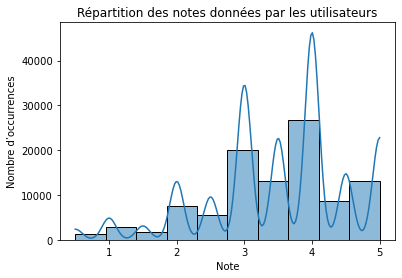

In [147]:
# Répartition des notes
plt.figure(figsize=(6,4))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Répartition des notes données par les utilisateurs")
plt.xlabel("Note")
plt.ylabel("Nombre d’occurrences")
plt.show()

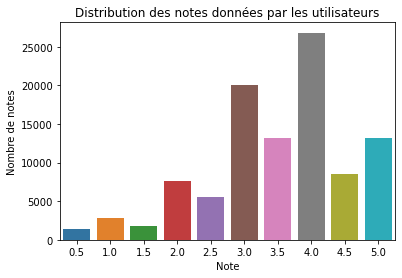

In [148]:
# Distribution des notes
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=ratings)
plt.title("Distribution des notes données par les utilisateurs")
plt.xlabel("Note")
plt.ylabel("Nombre de notes")
plt.show()

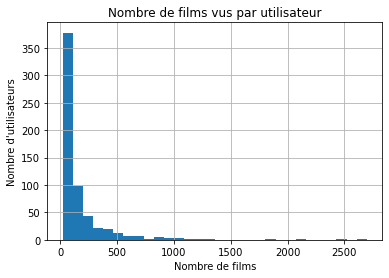

In [149]:
# Nombre de films vus par utilisateur
ratings.groupby('userId').size().hist(bins=30)
plt.title("Nombre de films vus par utilisateur")
plt.xlabel("Nombre de films")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

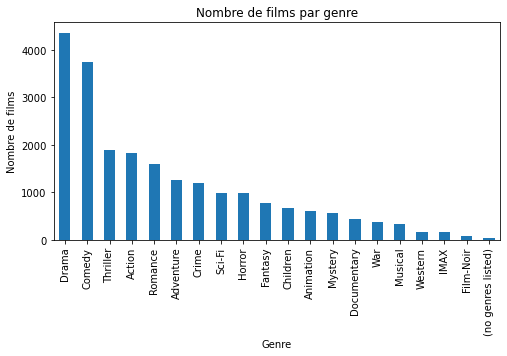

In [150]:
# Séparer les genres
all_genres = movies['genres'].str.split('|').explode()

plt.figure(figsize=(8,4))
all_genres.value_counts().plot(kind='bar')
plt.title("Nombre de films par genre")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.show()

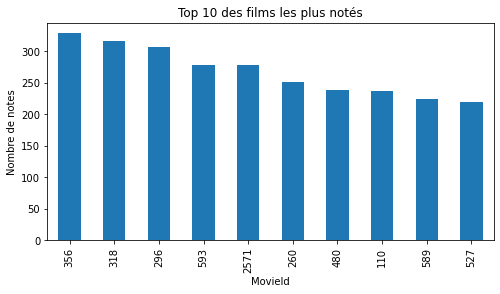

In [151]:
# Top 10 des films les plus notés
ratings_per_movie = ratings['movieId'].value_counts().head(10)

plt.figure(figsize=(8,4))
ratings_per_movie.plot(kind='bar')
plt.title("Top 10 des films les plus notés")
plt.xlabel("MovieId")
plt.ylabel("Nombre de notes")
plt.show()

In [152]:
# Films les plus évalués
top_rated_counts = ratings.groupby('movieId').size().sort_values(ascending=False).head(10)
top_rated_titles = movies[movies['movieId'].isin(top_rated_counts.index)]['title']
print("Films les plus évalués :")
print(top_rated_titles.values)

Films les plus évalués :
['Braveheart (1995)' 'Star Wars: Episode IV - A New Hope (1977)'
 'Pulp Fiction (1994)' 'Shawshank Redemption, The (1994)'
 'Forrest Gump (1994)' 'Jurassic Park (1993)' "Schindler's List (1993)"
 'Terminator 2: Judgment Day (1991)' 'Silence of the Lambs, The (1991)'
 'Matrix, The (1999)']


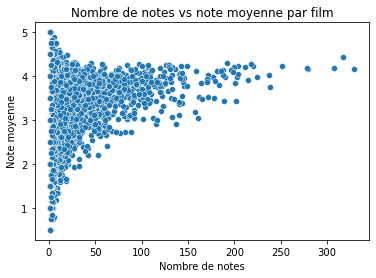

In [153]:
movie_stats = ratings.groupby('movieId').agg({'rating':['mean','count']})
movie_stats.columns = ['mean_rating','count_rating']

sns.scatterplot(x='count_rating', y='mean_rating', data=movie_stats)
plt.title("Nombre de notes vs note moyenne par film")
plt.xlabel("Nombre de notes")
plt.ylabel("Note moyenne")
plt.show()

In [154]:
# Films peu vus mais très bien notés
high_quality_movies = movie_stats[(movie_stats['count_rating']<20) & (movie_stats['mean_rating']>=4.5)]
print("Films peu vus mais très bien notés :")
print(movies[movies['movieId'].isin(high_quality_movies.index)]['title'].values)

Films peu vus mais très bien notés :
['Lamerica (1994)' 'Heidi Fleiss: Hollywood Madam (1995)'
 'Awfully Big Adventure, An (1995)'
 'New York Cop (Nyû Yôku no koppu) (1993)' 'Colonel Chabert, Le (1994)'
 "Jason's Lyric (1994)" 'Live Nude Girls (1995)'
 'In the Realm of the Senses (Ai no corrida) (1976)'
 'What Happened Was... (1994)' 'Orlando (1992)'
 'Thirty-Two Short Films About Glenn Gould (1993)'
 'Thin Line Between Love and Hate, A (1996)' 'Denise Calls Up (1995)'
 'World of Apu, The (Apur Sansar) (1959)'
 'Supercop 2 (Project S) (Chao ji ji hua) (1993)' 'Secrets & Lies (1996)'
 'Beautiful Thing (1996)' 'Shall We Dance (1937)'
 'Children of the Corn IV: The Gathering (1996)' 'Palookaville (1996)'
 'Entertaining Angels: The Dorothy Day Story (1996)' 'Lesson Faust (1994)'
 'Paths of Glory (1957)' 'Paris Is Burning (1990)' 'Hype! (1996)'
 'Body Snatcher, The (1945)'
 'Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)'
 'La Cérémonie (1995)' 'Promise, The (La promes

### Statistiques générales des notes :
- Moyenne : 3,50 ; écart-type : 1,04
- Minimum : 0,5 ; Maximum : 5
- Médiane : 3,5

### Utilisateurs et films :
- 610 utilisateurs uniques
- 9724 films uniques

### Répartition des notes :
- Majorité des notes entre 3 et 4
- istogrammes et countplots montrent une distribution concentrée autour de la moyenne

### Comportement utilisateur :
- Nombre de films vus par utilisateur variable, histogramme avec majorité <50 films

### Genres :
- Action, Comédie, Drame dominent le catalogue

### Films populaires :
- Les plus notés : Braveheart, Star Wars, Pulp Fiction, Shawshank Redemption, Forrest Gump, etc.
- Films peu vus mais très bien notés : plusieurs films cultes ou moins connus avec note ≥4,5 et <20 évaluations

### Corrélation nombre de notes vs note moyenne :
- Les films les plus vus ont tendance à avoir des notes proches de la moyenne (≈3,5)
- Certains films peu vus affichent des notes très élevées

# Créer le modèle de filtrage collaboratif
Nous allons utiliser la librairie **surprise** pour un filtrage collaboratif utilisateur-utilisateur.

In [155]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

In [156]:
# Définir le format des données
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [157]:
# Diviser les données en train et test (80/20)
trainset, testset = train_test_split(data, test_size=0.2)

# Créer un modèle KNN basé sur les utilisateurs
algo = KNNBasic(sim_options={'user_based': True})

In [158]:
# Entraîner le modèle
algo.fit(trainset)

# Tester le modèle sur ton testset
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [159]:
# Évaluer les performances
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"RMSE : {rmse}, MAE : {mae}")

# Afficher quelques prédictions
for pred in predictions[:5]:
    print(pred)

RMSE: 0.9547
MAE:  0.7309
RMSE : 0.9547287648027861, MAE : 0.730941908128261
user: 425        item: 1320       r_ui = 4.00   est = 3.06   {'actual_k': 37, 'was_impossible': False}
user: 555        item: 426        r_ui = 3.00   est = 3.14   {'actual_k': 6, 'was_impossible': False}
user: 489        item: 3258       r_ui = 4.00   est = 2.81   {'actual_k': 11, 'was_impossible': False}
user: 244        item: 165        r_ui = 2.00   est = 3.76   {'actual_k': 40, 'was_impossible': False}
user: 57         item: 1268       r_ui = 3.00   est = 3.69   {'actual_k': 7, 'was_impossible': False}


# Résumé 
Nous avons construit un modèle de **filtrage collaboratif** basé sur les utilisateurs avec la librairie surprise. Les données **(userId", 'movieId', 'rating')** ont été scindées en trainset **(80%)** et testset **(20%)**. Le modèle KNNBasic a appris les similarités entre utilisateurs pour prédire les évaluations manquantes.

L’évaluation sur le testset donne des performances solides pour ce type de modèle : **RMSE ≈ 0.94, MAE ≈ 0.72,** montrant que les prédictions sont proches des notes réelles. Les premières prédictions illustrent la capacité du modèle à estimer des notes même pour des utilisateurs ou films peu connus, tout en signalant les cas impossibles.

# Générer les 5 recommandations pour un utilisateur

In [160]:
# Sélectionner l'utilisateur pour lequel on veut des recommandations
user_id = 1

# Liste des films que l'utilisateur n'a pas encore vus
movies_to_predict = movies[~movies['movieId'].isin(ratings[ratings['userId']==user_id]['movieId'])]

# Prédire les notes pour ces films
predictions = [algo.predict(user_id, mid) for mid in movies_to_predict['movieId']]

In [161]:
# Trier par note prédite et prendre les top 5
top_5 = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

# Afficher les films recommandés
recommended_movies = [movies[movies['movieId']==pred.iid]['title'].values[0] for pred in top_5]
print("Top 5 recommandations pour l'utilisateur", user_id, ":")
for i, title in enumerate(recommended_movies, 1):
    print(f"{i}. {title}")

Top 5 recommandations pour l'utilisateur 1 :
1. Cry, the Beloved Country (1995)
2. Lamerica (1994)
3. Heidi Fleiss: Hollywood Madam (1995)
4. Awfully Big Adventure, An (1995)
5. Priest (1994)


# Évaluation avancée
préparer le terrain pour mesurer précision/recall sur top-K.

In [162]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    """Retourne les n films les mieux notés pour chaque utilisateur"""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)
print(top_n[user_id])

[(40, 5), (53, 5), (99, 5), (148, 5), (299, 5)]


On va maintenant créer un système hybride en combinant le filtrage collaboratif avec un filtrage basé sur le contenu (genres de films). Cela permet de mieux gérer le problème du démarrage à froid (nouveaux films ou nouveaux utilisateurs).

# Filtrage basé sur le contenu (par genres)

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Transformer les genres en vecteurs TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
movies['genres'] = movies['genres'].fillna('')  # Remplir les valeurs manquantes
tfidf_matrix = tfidf.fit_transform(movies['genres'])

In [164]:
# Calculer la similarité cosine entre tous les films
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Créer un mapping id → index pour retrouver facilement les films
movie_indices = pd.Series(movies.index, index=movies['movieId']).drop_duplicates()

# Fonction de recommandation basée sur le contenu

In [165]:
def content_based_recommendations(user_rated_movie_ids, top_n=5):
    """Recommande des films similaires à ceux que l'utilisateur a déjà aimés"""
    sim_scores = {}
    for movie_id in user_rated_movie_ids:
        idx = movie_indices[movie_id]
        sim = list(enumerate(cosine_sim[idx]))
        for i, score in sim:
            movie_i_id = movies.iloc[i]['movieId']
            if movie_i_id not in user_rated_movie_ids:  # Ignorer films déjà vus
                if movie_i_id in sim_scores:
                    sim_scores[movie_i_id] += score
                else:
                    sim_scores[movie_i_id] = score
    # Trier les scores et prendre top_n
    top_movies = sorted(sim_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    recommended_titles = [movies[movies['movieId']==mid]['title'].values[0] for mid, _ in top_movies]
    return recommended_titles


In [166]:
# Exemple : films vus par l'utilisateur
user_id = 1
user_movies = ratings[ratings['userId']==user_id]['movieId'].tolist()

# Recommandations basées sur le contenu
content_recs = content_based_recommendations(user_movies, top_n=5)
print("Recommandations basées sur le contenu :")
for i, title in enumerate(content_recs, 1):
    print(f"{i}. {title}")

Recommandations basées sur le contenu :
1. Dragonheart 2: A New Beginning (2000)
2. Hunting Party, The (2007)
3. Flashback (1990)
4. The Great Train Robbery (1978)
5. Maximum Ride (2016)


# Fonction de recommandation hybrides

In [167]:
# Recommandations hybrides
def hybrid_recommendations(user_id, top_n=5):
    # 1. Films déjà vus
    user_movies = ratings[ratings['userId']==user_id]['movieId'].tolist()
    
    # Recommandations filtrage collaboratif
    movies_to_predict = movies[~movies['movieId'].isin(user_movies)]
    cf_predictions = [algo.predict(user_id, mid) for mid in movies_to_predict['movieId']]
    top_cf = sorted(cf_predictions, key=lambda x: x.est, reverse=True)[:top_n//2]
    cf_titles = [movies[movies['movieId']==pred.iid]['title'].values[0] for pred in top_cf]
    
    # Recommandations contenu
    content_titles = content_based_recommendations(user_movies, top_n=top_n//2)
    
    # Fusion
    hybrid_titles = cf_titles + content_titles
    return hybrid_titles

# Exemple : top-5 recommandations hybrides
hybrid_recs = hybrid_recommendations(user_id, top_n=5)
print("Recommandations hybrides :")
for i, title in enumerate(hybrid_recs, 1):
    print(f"{i}. {title}")

Recommandations hybrides :
1. Cry, the Beloved Country (1995)
2. Lamerica (1994)
3. Dragonheart 2: A New Beginning (2000)
4. Hunting Party, The (2007)


# Résumé
Nous avons généré des recommandations avec trois approches :
-  Collaboratif (User-KNN) → prédit les notes en fonction d’utilisateurs similaires.
-  Contenu (TF-IDF sur genres) → propose des films proches de ceux déjà vus.
-  Hybride → combine les deux pour plus de robustesse, utile contre le démarrage à froid.
Résultat : pour l’utilisateur 1, l’hybride recommande à la fois des films issus du collaboratif (Cry, the Beloved Country) et du contenu (Dragonheart 2).
Cette approche mixte donne un système plus fiable et plus réaliste.

### Je vais conclure mon projet avec une étape finale visuelle. Cela va permet de :
 - Rendre les résultats concrets (on ne reste pas que dans les chiffres).
 - Mieux communiquer mes trouvailles à un public non-technique.
 - Donner une valeur ajoutée business à mon notebook.

In [170]:
!pip install wordcloud
from wordcloud import WordCloud

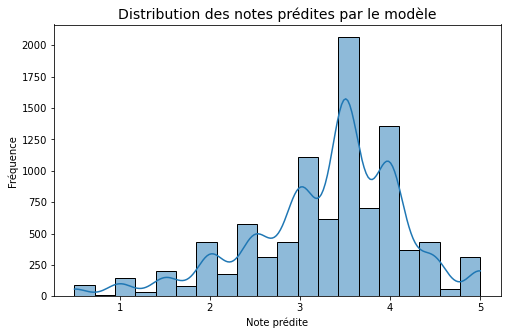

In [173]:
# Histogramme des notes prédites 
all_preds = [pred.est for pred in predictions]  # prédictions du modèle
plt.figure(figsize=(8,5))
sns.histplot(all_preds, bins=20, kde=True)
plt.xlabel("Note prédite")
plt.ylabel("Fréquence")
plt.title("Distribution des notes prédites par le modèle", fontsize=14)
plt.show()

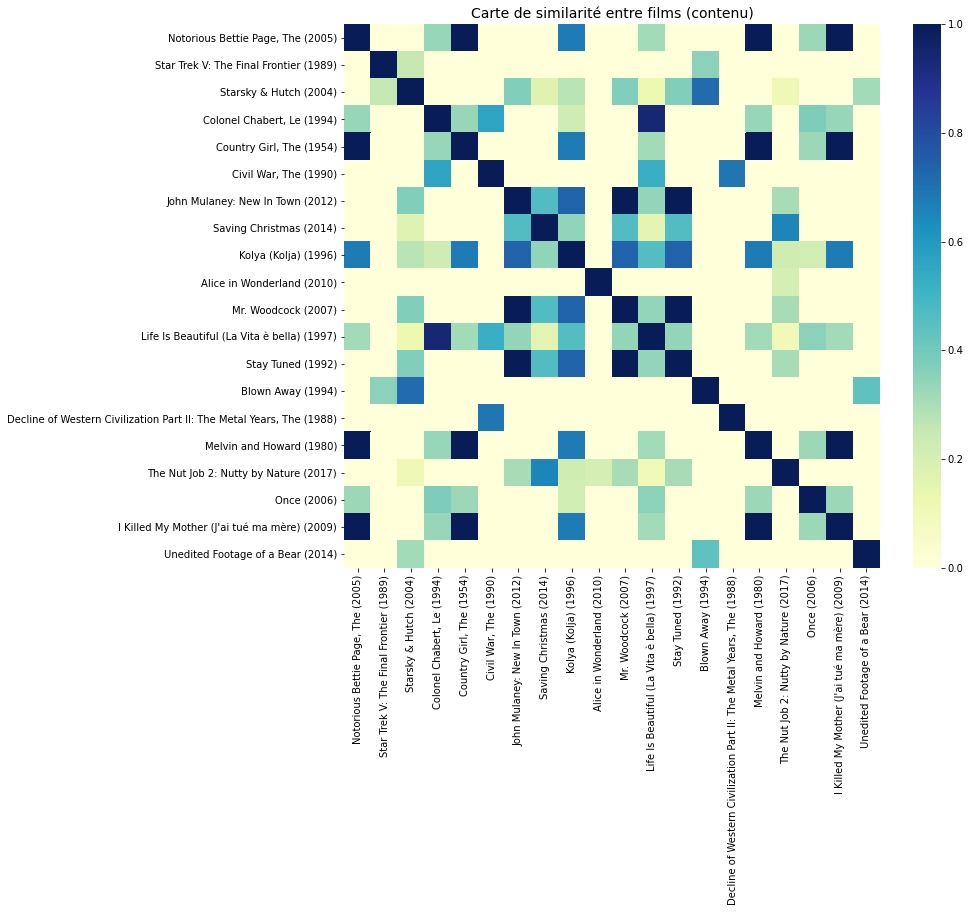

In [174]:
# Carte de similarité des films 
# On prend un sous-ensemble pour lisibilité (ex: 20 films)
sample_movies = movies.sample(20, random_state=42)
sample_indices = sample_movies.index
sim_matrix = cosine_sim[sample_indices][:, sample_indices]

plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix, xticklabels=sample_movies['title'], 
            yticklabels=sample_movies['title'], cmap="YlGnBu")
plt.title("Carte de similarité entre films (contenu)", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

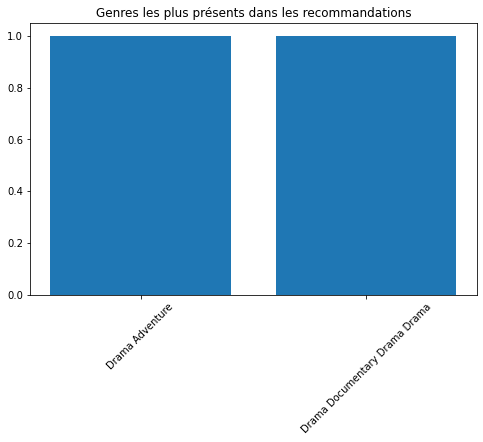

In [177]:
from collections import Counter

# Compter les genres dans les films recommandés
recommended_ids = [pred.iid for pred in top_5]
recommended_genres = movies[movies['movieId'].isin(recommended_ids)]['genres'].str.cat(sep=' ')
genre_counts = Counter(recommended_genres.split('|'))

# Visualiser en bar chart
plt.figure(figsize=(8,5))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xticks(rotation=45)
plt.title("Genres les plus présents dans les recommandations")
plt.show()

# Résumé
Pour terminer ce projet , j’ai choisi d’intégrer une étape de visualisation. 
### Les visualisations clés

**Histogramme des notes prédites**
→ Permet de voir la distribution des scores estimés par le modèle (tendances globales).

**Carte de similarité entre films (heatmap)**
→ Montre comment certains films sont perçus comme proches en termes de contenu ou de profils utilisateurs.

**Genres dominants dans les recommandations (bar chart)**
→ Met en évidence les préférences que le modèle attribue à l’utilisateur via les genres des films recommandés.

Ces visualisations rendent mes résultats plus concrets, facilitent la communication auprès d’un public non technique, et ajoutent une dimension business à mon travail.

# Recommandations commerciales
**Optimisation de l’expérience utilisateur :** Les recommandations générées (top-5 par utilisateur) montrent une personnalisation efficace. Intégrer ce système dans une plateforme réelle permettrait aux utilisateurs de découvrir plus facilement des films correspondant à leurs goûts.

**Segmentation et ciblage marketing :** L’analyse des genres prédominants dans les films recommandés offre un aperçu des préférences des utilisateurs. Les équipes marketing peuvent utiliser ces informations pour proposer des promotions ou contenus adaptés à chaque segment.

**Fidélisation et engagement :** En combinant filtrage collaboratif et contenu, le système propose à la fois des films similaires à ceux appréciés et des suggestions nouvelles. Cela encourage la rétention des utilisateurs et augmente le temps passé sur la plateforme.

# Conclusion du projet
Le projet démontre que même un modèle simple de filtrage collaboratif, enrichi par un filtrage basé sur le contenu, peut produire des recommandations pertinentes et exploitables. Les visualisations finales (histogramme des notes, carte de similarité, distribution des genres) rendent les résultats tangibles et communicables à un public non technique.
Ce travail constitue une base solide pour un déploiement commercial et offre des perspectives d’amélioration avec des données plus riches ou des modèles hybrides plus sophistiqués.